# Load Data

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, resize
import os
import random
import torchvision.transforms as tf
import torch.nn.functional as F
import torch.optim.lr_scheduler as sc

In [ ]:
imgs_tr = []
imgs_val = []
masks_tr = []
masks_val = []
path_imgs = "./Pascal-part/JPEGImages"
path_masks  = "./Pascal-part/gt_masks"

# load imgs/masks id's
with open("./Pascal-part/train_id.txt", "r") as f1, open("./Pascal-part/val_id.txt", "r") as f2:
  train_id = [line.rstrip('\n') for line in f1]
  val_id = [line.rstrip('\n') for line in f2]


for img in os.listdir(path_imgs):
    path_img = os.path.join(path_imgs, img)
    path_mask = os.path.join(path_masks, img.rstrip(".jpg") + ".npy")
    # load train set
    if img.rstrip(".jpg") in train_id:
      imgs_tr.append(Image.open(path_img))
      masks_tr.append(torch.from_numpy(np.load(path_mask)))
    # load valid set
    if img.rstrip(".jpg") in val_id:
      imgs_val.append(Image.open(path_img))
      masks_val.append(torch.from_numpy(np.load(path_mask)))




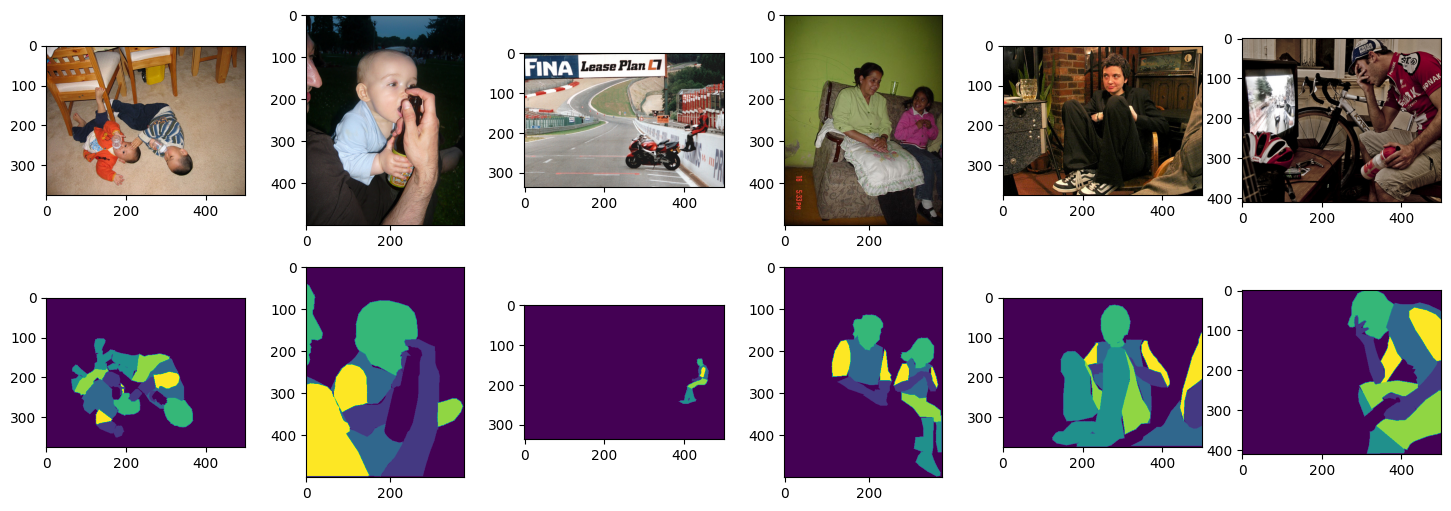

In [ ]:
plt.figure(figsize=(18, 6))

for i in range(6):
    j = np.random.randint(0, len(imgs_val) - 1)
    plt.subplot(2, 6, i+1)
    #plt.axis("off")
    plt.imshow(imgs_val[j])

    plt.subplot(2, 6, i+7)
    #plt.axis("off")
    plt.imshow(masks_val[j])
plt.show();

# Utils

In [ ]:
def show_images(images, masks, nmax=8):

    plt.figure(figsize=(18, 6))
    for i in range(nmax):
        plt.subplot(4, nmax, i+1)
        plt.axis("off")
        plt.imshow(images[i].permute(1,2,0))

        # body
        plt.subplot(4, nmax, i+nmax+1)
        plt.axis("off")
        plt.imshow(masks[i][0])

        # upper body
        plt.subplot(4, nmax, i+2*nmax+1)
        plt.axis("off")
        plt.imshow(masks[i][1])

        #lower body
        plt.subplot(4, nmax, i+3*nmax+1)
        plt.axis("off")
        plt.imshow(masks[i][2])
    plt.show()



def show_batch(dl, nmax=8):
    for images, masks in dl:
        assert nmax <= len(images), "Number of images exceeds batch size"
        show_images(images, masks, nmax)
        break

# Create Dataset

In [ ]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet101', pretrained='imagenet')

In [ ]:
labels = {
    'background': 0,
    'low_hand': 1,
    'torso' : 2,
    'low_leg' : 3,
    'head' : 4,
    'up_leg' : 5,
    'up_hand' : 6
}
hierarchy = {
    0 : [labels["head"], labels["torso"], labels["up_hand"], labels["low_hand"], labels["up_leg"], labels["low_leg"]],
    1 : [labels["head"], labels["torso"], labels["up_hand"], labels["low_hand"]],
    2 : [labels["up_leg"], labels["low_leg"]],
    3 : [labels["head"]],
    4 : [labels["torso"]],
    5 : [labels["up_hand"]],
    6 : [labels["low_hand"]],
    7 : [labels["up_leg"]],
    8 : [labels["low_leg"]],
}

In [ ]:
class toNumpy:
  def __call__(self, image : torch.Tensor):
    return image.numpy()

class ResNetNormalize:
  """
  Normalization for resnet50 backbone trained on imagenet
  """
  def __call__(self, image : np.array):
    return preprocess_input(np.moveaxis(image, 0, 2))

class SquarePad:
  """
  Adds padding, so the Resize doesn't distort original image proportions
  """
  def __call__(self, image):
    if isinstance(image, torch.Tensor):
        h, w = image.size()
    else:
        w, h = image.size

    max_wh = np.max([w, h])
    hp = int((max_wh - w) / 2)
    vp = int((max_wh - h) / 2)
    padding = (hp, vp, hp, vp)
    if isinstance(image, torch.Tensor):
      return F.pad(image, padding, 'constant', 0.).unsqueeze(0)
    else:
      return F.pad(pil_to_tensor(image), padding, 'constant', 0.)


class Pascal_Part_Dataset(Dataset):

    def __init__(self, imgs : list, masks : list, augment = True, image_size = 224):
        super().__init__()

        assert len(imgs) == len(masks), "Number of imgs must be equal to the number of masks"

        self.imgs = imgs
        self.masks = masks
        self.len_ = len(self.imgs)
        self.image_size = image_size
        self.augment = augment

        self.transform_img=tf.Compose([
            SquarePad(),
            tf.Resize(image_size),
            tf.CenterCrop(image_size),
            toNumpy(),
            ResNetNormalize(),
            tf.ToTensor()
        ])

        self.transform_mask =tf.Compose([
            SquarePad(),
            tf.Resize(image_size, interpolation=tf.InterpolationMode.NEAREST), # no interpolation for masks to keep the correct class labels
            tf.CenterCrop(image_size),
        ])
        #self.bin_masks = torch.zeros(9,224,224) # 9 binary masks for each class of hierarchy


    def augmentation(self, image, mask):
        # Random Resized Square Crop
        i, j, h, w = tf.RandomResizedCrop.get_params(image, scale = (0.4, 1.0), ratio = (1.0,1.0)) # get random parameters
        image = tf.functional.crop(image, i, j, h, w)
        mask = tf.functional.crop(mask,i, j, h, w)
        image = tf.functional.resize(image, self.image_size)
        mask = tf.functional.resize(mask, self.image_size, interpolation=tf.InterpolationMode.NEAREST) # no interpolation for masks to keep the correct class labels

        # Random horizontal flipping
        if random.random() > 0.5:
            image = tf.functional.hflip(image)
            mask = tf.functional.hflip(mask)

        return image, mask

    def get_binary_masks(self, mask, body_parts : list):
        """
        Generates a map for particular hierarchy level combining body parts
        """
        new_mask = torch.zeros_like(mask)
        for part in body_parts:
          new_mask = torch.where(mask == part,1.0, new_mask)
        return new_mask.squeeze(0)

    def __len__(self):
        return self.len_

    def __getitem__(self, i):
        img = self.transform_img(self.imgs[i])
        mask = self.transform_mask(self.masks[i])

        if self.augment:
          img, mask = self.augmentation(img, mask)

        bin_masks = torch.zeros(9,224,224)
        for j in range(9):
          bin_masks[j] = self.get_binary_masks(mask, hierarchy[j])

        return img.float(), bin_masks.float()


In [ ]:
val_set = Pascal_Part_Dataset(imgs_val, masks_val, augment = False)
tr_set = Pascal_Part_Dataset(imgs_tr, masks_tr)

In [ ]:
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
tr_loader = DataLoader(tr_set, batch_size=16, shuffle=True)

# Change U-Net's (backbone ResNet-50) segmentation head to multi-label pixel classification

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet101",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=9                    # model output channels (number of classes in your dataset)
)

In [ ]:
# Freeze weigths of the encoder
for param in model.encoder.parameters():
    param.requires_grad = False
# Add sigmoid activation
model.segmentation_head[2].activation = torch.nn.Sigmoid()

In [ ]:
from torchinfo import summary
summary(model,input_size=(16, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [16, 9, 224, 224]         --
├─ResNetEncoder: 1-1                          [16, 3, 224, 224]         --
│    └─Conv2d: 2-1                            [16, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [16, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [16, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [16, 64, 56, 56]          --
│    └─Sequential: 2-5                        [16, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [16, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [16, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                   [16, 256, 56, 56]         (70,400)
│    └─Sequential: 2-6                        [16, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [16, 512, 28, 28]      

# Inference

In [ ]:
tree_paths = [
    [0, 1, 6], # low arm leaf
    [0, 1, 4], # torso leaf
    [0, 2, 8], # low leg leaf
    [0, 1, 3], # head leaf
    [0, 2, 7], # upper leg leaf
    [0, 1, 5]  # upper hand leaf
   ]

In [ ]:
def inference(scores):
  """
  scores: output from network BxCxWxH
  Finds argmax path in hierarchy tree
  """
  #pred = torch.zeros((scores.size()[0], 224, 224), dtype = torch.uint8)
  path_sums = torch.zeros((scores.size()[0], 6, 224, 224))
  for i, path in enumerate(tree_paths):
    path_sums[:,i] = scores[:,path].mean(1)

  indx = torch.argmax(path_sums, dim = 1) # Bx224x224
  pred = torch.zeros_like(scores)
  for i in range(6):
      # pred[:, tree_path].shape = Bx3xWxH, indx.shape = BxWxH -> resize for broadcasting along singlton dimension Bx1xWxH
      pred[:,tree_paths[i]] = torch.where(indx.view(-1, 1, 224,224)  == i, scores[:,tree_paths[i]], pred[:,tree_paths[i]])
  return pred

# Tree Focal Loss

In [ ]:
levels = {"1":[1,2],"2":[3,4,5,6,7,8]} # the 2nd an 3rd levels of the pascal part hierarchy tree
def corr_seg_map(scores, masks):
  """
  Args:
        scores (Tensor): A float tensor of the shape BxCxHxW
        masks (Tensor): A float tensor of the shape BxCxHxW
  This function corrects segmentation map from segmentation head, so it's hierarchy-coherent:
  (i) if a class is labeled positive, all its ancestor nodes should be labeled positive
  (ii) if a class is labeled negative, all its child nodes should be labeled negative
  """
  # pos = 1
  # neg = torch.tensor([0.0])
  corr_scores = torch.zeros_like(scores,  device=scores.device)
  # positive target (1) top-down propagation

  for l in levels["1"]:
      corr_scores[:,l] = torch.where(~(masks[:,l].type(torch.uint8) ==  1), scores[:,l], torch.minimum(scores[:,0], scores[:,l]))

  # modified values of level 1
  n1 = corr_scores[:,1].clone() # nodes 1,2
  n2 = corr_scores[:,2].clone()

  for l in levels["2"]:
      corr_scores[:,l] = torch.where(~(masks[:,l].type(torch.uint8) ==  1), scores[:,l],
                                     torch.minimum(n1, scores[:,l]) if l < 7 else torch.minimum(n2, scores[:,l])
                                    )

  # negative traget(0) bottom-up propagation
  for l in levels["1"]:
        for l1 in levels["2"]:
          cond2 = (masks[:,l].type(torch.uint8) ==  0)  & (masks[:,l1].type(torch.uint8) == 0) & (((l < 2 and l1 < 7) or (l > 1 and l1 > 6)))
          corr_scores[:,l] = torch.where(cond2, torch.maximum(scores[:,l1], scores[:,l]), scores[:,l])

  # modified values of level 1
  n1 = corr_scores[:,1].clone() # nodes 1,2
  n2 = corr_scores[:,2].clone()
  n12 = torch.maximum(n1, n2)
  corr_scores[:,0] = torch.where(~(masks[:,0].type(torch.uint8) ==  0), scores[:,0],  torch.maximum(n12, scores[:,0]))
  #orr_scores[:,0] = scores[:,0]

  return corr_scores

def binary_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    gamma: float = 2
) -> torch.Tensor:
    """
    Reimplemintations of official pytorch focal loss:
    https://pytorch.org/vision/main/_modules/torchvision/ops/focal_loss.html

    Focal BCELoss reduction is always "mean", i.e. cross-enthropy per pixel
    inputs: activations after sigmoid or softmax
    targets: "one-hot" tensors
    gamma: focusing parameter
    """
    ce_loss = F.binary_cross_entropy(inputs, targets, reduction="none")
    p_t = inputs * targets + (1 - inputs) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)
    return loss.mean()

def tree_loss(scores, masks):
    return F.binary_cross_entropy(corr_seg_map(scores, masks), masks)

def focal_tree_min_loss(scores, masks, gamma = 2):
  return binary_focal_loss(corr_seg_map(scores, masks), masks, gamma = gamma)


# IoU metric

In [ ]:
def IoU(outputs: torch.Tensor, labels: torch.Tensor):
    """
    Implementation of IoU, labels can be floats.
    Metric Reduction: mean over batch
    Threshold is 0.5 and implemented with torch.round()
    Returns: IoU for each channel summed over batch
    """
    outputs = torch.round(outputs).byte()  # BATCH x C x H x W
    labels = torch.round(labels).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((2, 3))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((2, 3))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean(0)  # sum over BATCH

In [ ]:
hier_levels = {
    'body': [0],
    'up_low_body': [1,2],
    'body_parts' : [3,4,5,6,7,8]
}

def get_mean_IoU(infer_masks, tar_masks):
  """
  Returns mmean IoU score for each level of hierarchy summed over batches
  """
  # calculate mean IoU for each level of hierarchy
  ious = IoU(infer_masks, tar_masks)
  lev1 = ious[hier_levels["body"]].item()
  lev2 = ious[hier_levels["up_low_body"]].mean().item()
  lev3 = ious[hier_levels["body_parts"]].mean().item()
  return lev1, lev2, lev3

# Training loop

In [ ]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # decay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)

# Warmup + Scheduler
number_warmup_epochs = 2
def warmup(current_step: int):
    return 1 / (10 ** (float(number_warmup_epochs - current_step)))

warmup = sc.LambdaLR(optimizer, lr_lambda=warmup)
step_lr = sc.StepLR(optimizer, step_size=8, gamma=0.1)

scheduler = sc.SequentialLR(optimizer, schedulers=[warmup, step_lr], milestones=[number_warmup_epochs])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [ ]:
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

def save_model(curr_epoch, model, optim, scheduler, losses, log_name):
    # сохраняем модель
    torch.save({'epoch': curr_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'scheduler' : scheduler.state_dict(),
        'losses' : losses,
        }, log_name + ".pt"
    )

In [ ]:
def visualize(masks, preds, nmax=8):

    plt.figure(figsize=(18, 6))
    for i in range(nmax):
        plt.subplot(4, nmax, i+1)
        plt.axis("off")
        plt.title("true mask")
        plt.imshow(masks[i][0], cmap = "grey")

        plt.subplot(4, nmax, i+nmax+1)
        plt.axis("off")
        plt.title("pred mask")
        plt.imshow(torch.round(preds[i][0]), cmap = "grey")

        plt.subplot(4, nmax, i+2*nmax+1)
        plt.axis("off")
        plt.title("pred prob map")
        plt.imshow(preds[i][0], cmap = "grey")
    plt.show()

In [ ]:
def train(model, opt, sched, loss_fn, inference, metric, epochs, data_tr, data_val,*, log_name = None):
    if log_name is None:
        raise RuntimeError("Enter log_name")
    model.to(device)

    # logging
    log_template = "epoch: {ep:3d}, train_loss: {t_loss:2.3f}, val_loss {v_loss:2.3f}, \
    IoU_lev1: {lev1:1.1f}, IoU_lev2: {lev2:1.1f}, IoU_lev3: {lev3:1.1f}, lr : {lr: 0.4f}"
    writer = SummaryWriter("runs_a_bce_s/" + log_name)

    # normalization coef to calculate loss and metrics per epoch
    n_tr =  len(data_tr.dataset)
    n_val = len(data_val.dataset)

    history = []
    best_iou = 0.3
    for epoch in tqdm(range(epochs)):
        val_loss = 0.
        train_loss = 0.
        iou1 = iou2  = iou3 = 0.0
        iouTr = 0.0
        # TRAINING
        model.train()
        for imgs, masks in data_tr:
            # set parameter gradients to zero


            # forward
            #scores = model(imgs.to(device))
            scores = model(imgs.to(device))
            loss =  loss_fn(scores, masks.to(device))
            #loss =  loss_fn(scores, masks.to(device))
            loss.backward()
            opt.step()
            opt.zero_grad()

            # accumulate loss
            train_loss += loss.item()*imgs.size(0)  # TB

            # scores = F.sigmoid(logits) # use it with BCEWithLogitsLoss
            pred = inference(scores.detach().cpu())

            # acumulate metrics
            ious = metric(pred, masks)
            iouTr += ious[0]* imgs.size(0)

        # VALIDATION
        model.eval()
        for imgs, masks in data_val:

            with torch.no_grad():
                scores = model(imgs.to(device))
                loss = loss_fn(scores, masks.to(device))

                val_loss += loss.item()*imgs.size(0) # TB

                # inference
                # scores = F.sigmoid(logits) # use it with BCEWithLogitsLoss
                pred = inference(scores.cpu())

                # acumulate metrics
                ious = metric(pred, masks)
                iou1 += ious[0] * imgs.size(0); iou2 += ious[1] * imgs.size(0); iou3 += ious[2]* imgs.size(0) # TB

        # SCHEDULER
        sched.step()
        # LOGGING
        train_loss /= n_tr; val_loss /= n_val;  iou1/=n_val; iou2/=n_val; iou3/=n_val; iouTr /= n_tr
        print(log_template.format(ep = epoch + 1, t_loss = train_loss, \
                                 v_loss = val_loss, lev1 = iou1, lev2 = iou2, lev3 = iou3, lr = opt.param_groups[0]["lr"]))
        history.append((train_loss, val_loss, iou1, iou2, iou3))

        writer.add_scalars('Losses', {'train_loss': train_loss, 'val_loss': val_loss}, epoch+1)
        writer.add_scalars('Metrics', {'IoU1' : iou1, 'IoU2' : iou2, 'IoU3' : iou3}, epoch+1)
        writer.add_scalars('Tr_Val_metric', {'IoU_Tr' : iouTr, 'IoU_Val' : iou1}, epoch+1)
        # SAVE CHECKPONTS
        if (epoch + 1)%20 == 0:
          save_model(epoch + 1, model, optimizer, sched, history, log_name + f"_{epoch + 1}")

        if best_iou < (avg := (iou1 + iou2 + iou3)/3):
          save_model(epoch + 1, model, optimizer, sched,  history, log_name + "_best")
          best_iou = avg

        # VISUALIZE
        if (epoch + 1)%20== 0:
            imgs, masks = next(iter(data_tr))
            with torch.no_grad():
                logits = model(imgs.to(device))
            scores = F.sigmoid(logits)
            preds = inference(scores.cpu())
            visualize(masks, preds)

    return history

# Training

In [ ]:
epochs = 40
history = train(model, optimizer, scheduler, torch.nn.BCELoss(), inference, get_mean_IoU, epochs, tr_loader, val_loader, log_name = "pascal_adam_sc")